In [1]:
import torch
from torchtext.data import Field, LabelField, TabularDataset, BucketIterator
from torchtext import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv("../datasets/sentiment-analysis/tweets/tweets.csv", encoding="latin-1");
data = data.drop(columns=["ItemID", "SentimentSource"], axis=1);
data = data.rename(index=str, columns={"Sentiment":"label","SentimentText":"text"});
data.head()

,label,text
0,neg,is so sad for my APL frie...
1,neg,I missed the New Moon trail...
2,pos,omg its already 7:30 :O
3,neg,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,neg,i think mi bf is cheating on me!!! ...


In [3]:
train, test = train_test_split(data, test_size=0.2, random_state=42);
train.reset_index(drop=True), test.reset_index(drop=True)

(      label                                               text
 0       pos  @amyrenea omg so am I lol I fell asleep when i...
 1       neg               @Adrienne_Bailon I want a shout out 
 2       neg  @Anonymousboy03 Plans for school stuff &amp; a...
 3       neg  ... has hit a writer's block .. am loosing my ...
 4       neg  ... trying to find people I know! I`m bored, i...
 ...     ...                                                ...
 39995   pos   #robotpickuplines are so funny. check them out. 
 39996   pos  @annyo84 awh thankss.  yeah, i understand what...
 39997   pos  @AmbiguityX ohh you're in twin cities?  i luv ...
 39998   neg   Dinara lost again in Roland Garros. Why the S...
 39999   pos  *yawn* fucking time zones shit. I'm really sic...
 
 [40000 rows x 2 columns],
      label                                               text
 0      pos  @aimeesays aww i hope it does fly by because J...
 1      neg  #dontyouhate when you JUST painted yur nails a...
 2      neg  -

In [4]:
train.to_csv("../datasets/sentiment-analysis/tweets/tweets_train.csv", index=False);
test.to_csv("../datasets/sentiment-analysis/tweets/tweets_test.csv", index=False);

In [5]:
import spacy
import re
nlp = spacy.load("en_core_web_sm");

def clean_tweets(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text);
    text = re.sub(r'https?:/\/\S+', ' ', text);
    return text.strip();

def tokenizer(text):
    return [w.text.lower() for w in nlp(clean_tweets(text))];

In [6]:
TEXT = Field(tokenize = tokenizer, include_lengths = True);
LABEL = LabelField(dtype = torch.float);

datafields = [("label",LABEL), ("text",TEXT)];
trn, tst = TabularDataset.splits(path="../datasets/sentiment-analysis/tweets/",
                                train = "tweets_train.csv",
                                test = "tweets_test.csv",
                                format = "csv",
                                skip_header = True,
                                fields = datafields);

In [7]:
TEXT.build_vocab(trn, max_size=2500,
                vectors='glove.6B.100d',
                unk_init=torch.Tensor.normal_);
embedding_dim = 100;
vocab_size = len(TEXT.vocab);
LABEL.build_vocab(trn);

In [8]:
print(TEXT.vocab.freqs.most_common(50));

[('i', 25644), ('the', 12219), ('to', 12111), ('you', 10723), ('a', 9197), ('it', 8440), ('and', 6889), ('my', 6208), ('quot', 5582), ('s', 5565), ('that', 5306), ('is', 5203), ('for', 4971), ('in', 4852), ('t', 4844), ('m', 4683), ('me', 4588), ('of', 4331), ('on', 3918), ('have', 3752), ('so', 3612), ('but', 3506), ('be', 2932), ('not', 2887), ('was', 2775), ('just', 2724), ('can', 2523), ('do', 2418), ('are', 2351), ('your', 2320), ('with', 2269), ('good', 2203), ('like', 2173), ('at', 2131), ('no', 2119), ('this', 2094), ('all', 2069), ('up', 2066), ('now', 2063), ('get', 2044), ('we', 1988), ('u', 1890), ('love', 1885), ('lol', 1864), ('too', 1826), ('what', 1760), ('out', 1742), ('know', 1664), ('nt', 1608), ('amp', 1539)]


In [9]:
print(TEXT.vocab.itos[0:10]);

['<unk>', '<pad>', 'i', 'the', 'to', 'you', 'a', 'it', 'and', 'my']


In [10]:
batch_size = 32;
train_itr, test_itr = BucketIterator.splits((trn, tst),
                                            batch_size = batch_size,
                                            sort_key = lambda x: len(x.text),
                                            #sort=False,
                                            #shuffle=True,
                                            sort_within_batch=True);

In [11]:
import torch.nn as nn

class SentimentAnalysisModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__();
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx);
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, 
                           num_layers = n_layers, 
                           bidirectional = bidirectional,
                           dropout = dropout);
        self.fullyconnected = nn.Linear(hidden_dim*2, output_dim);
        self.dropout = nn.Dropout(dropout);
#         self.sigmoid = nn.Sigmoid()
        
    def forward(self, tweets, text_lengths):
        embedded = self.embedding(tweets);
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths);
        _,(hidden, _) = self.rnn(packed_embedded);
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1));
#         return self.sigmoid(self.fullyconnected(hidden));
        return self.fullyconnected(hidden);

In [12]:
model = SentimentAnalysisModel(vocab_size,
                              embedding_dim = 100,
                              hidden_dim = 256,
                              output_dim = 1,
                              n_layers = 2,
                              bidirectional = True,
                              dropout = 0.5,
                              pad_idx = TEXT.vocab.stoi[TEXT.pad_token]);

In [13]:
pretrained_embeddings = TEXT.vocab.vectors;
model.embedding.weight.data.copy_(pretrained_embeddings);
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(embedding_dim);
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.pad_token]] = torch.zeros(embedding_dim);

In [46]:
# for x in train_itr:
#     print(x.text)
#     break

print(LABEL.vocab.itos)

['pos', 'neg']


In [15]:
from tqdm import tqdm
import torch.optim as optim

n_epochs = 5;
optimizer = optim.Adam(model.parameters());
# loss_function = nn.BCELoss();
loss_function = nn.BCEWithLogitsLoss()

loss_stats = []
acc_stats = []
val_loss_stats = []
val_acc_stats = []
best_val_loss = 1
for epoch in range(n_epochs):
    # Train
    model.train();
    epoch_acc = 0;
    epoch_loss = 0;
    for batch in tqdm(train_itr):
        optimizer.zero_grad();
        text, text_lengths = batch.text;
        pred = model(text, text_lengths).squeeze();
        loss = loss_function(pred, batch.label)
#         rounded_pred = torch.round(pred);
        rounded_pred = torch.round(torch.sigmoid(pred));
        correct = rounded_pred == batch.label;
        acc = sum(correct.float())*100/len(correct);
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item();
        epoch_acc += acc.item();  
    epoch_loss = epoch_loss/len(train_itr)
    epoch_acc = epoch_acc/len(train_itr)
    loss_stats.append(epoch_loss)
    acc_stats.append(epoch_acc)
    
    # Validate
    model.eval();
    val_loss = 0;
    val_acc = 0;
    with torch.no_grad():        
        for batch in test_itr:
            text, text_lengths = batch.text;
            pred = model(text, text_lengths).squeeze();
            loss = loss_function(pred, batch.label)
#             rounded_pred = torch.round(pred);
            rounded_pred = torch.round(torch.sigmoid(pred));
            correct = rounded_pred == batch.label;
            acc = sum(correct.float())*100/len(correct);
            val_loss += loss.item();
            val_acc += acc.item();
    val_loss = val_loss/len(test_itr)
    val_acc = val_acc/len(test_itr)
    val_loss_stats.append(val_loss)
    val_acc_stats.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'sentiment_analysis_weights.pt')
    elif val_loss > best_val_loss:
        break
    
    print("Epoch:", epoch+1, ", Loss:", epoch_loss, ", Accuracy:", epoch_acc, "%", ", Val Loss:", val_loss, ", Val Accuracy:", val_acc,"%");

100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [08:44<00:00,  2.38it/s]


Epoch: 1 , Loss: 0.5314502973914147 , Accuracy: 72.9 % , Val Loss: 0.473991440031856 , Val Accuracy: 77.33626198083067 %


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [08:56<00:00,  2.33it/s]


Epoch: 2 , Loss: 0.462764978659153 , Accuracy: 77.755 % , Val Loss: 0.46405946475248366 , Val Accuracy: 77.36621405750799 %


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [08:49<00:00,  2.36it/s]


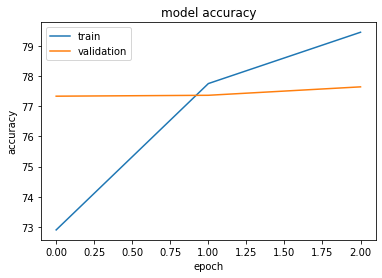

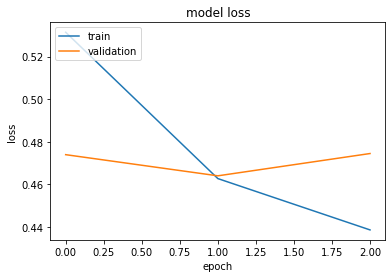

In [16]:
import matplotlib.pyplot as plt

plt.plot(acc_stats)
plt.plot(val_acc_stats)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
# plt.ylim(0.5,1)
plt.show()

plt.plot(loss_stats)
plt.plot(val_loss_stats)

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
# plt.ylim(0,1.5)
plt.show()

In [17]:
import pickle
output = open('sentiment_vocab.pkl', 'wb')
pickle.dump(TEXT.vocab, output)
output.close()